See code at https://github.com/google-research/vision_transformer/

This Colab is about the paper

- LiT: Zero-Shot Transfer with Locked-image text Tuning: https://arxiv.org/abs/2111.07991

For ViT, MLP Mixer etc see the other Colab

https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb

## My model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow import keras
import os
model = keras.models.load_model('/content/drive/MyDrive/TFG/trained_models/latest_31_08_2022_small_2.h5')

In [5]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras import callbacks
from keras.models import Model
import seaborn as sns

#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array

import pandas as pd
import numpy as np
import os
import gdown

from zipfile import ZipFile
import matplotlib.pyplot as plt

# We install the FER() library to perform facial recognition
# This installation will also take care of any of the above dependencies if they are missing
#!pip install FER
#from fer import FER


class_weights = {'age_output': {0: 2.0, 1: 2.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 2.0}, 
                 'expression_output': {0: 2.0, 1: 2, 2:1.0, 3:1, 4:2.0},
                 'gender_output':{0:1.0, 1:1.0},
                 'hair_output':{0:0.5, 1:2.0, 2:1.5, 3:0.5},
                 'eyeglasses_output':{0:0.5, 1:2.0},
                 'bald_output':{0:0.5, 1:2.0},
                 } 

#from keras.optimizers import Adam
init_lr = 1e-4
epochs = 100
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'expression_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy',
                  'hair_output': 'categorical_crossentropy',
                  'eyeglasses_output': 'binary_crossentropy',
                  'bald_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 1, 
                  'expression_output': 1.5, 
                  'gender_output': 0.5,
                  'hair_output': 0.5,
                  'eyeglasses_output': 1,
                  'bald_output': 1.5},
              metrics={
                  'age_output': 'accuracy', 
                  'expression_output': 'accuracy',
                  'gender_output': 'accuracy',
                  'hair_output': 'accuracy',
                  'eyeglasses_output': 'accuracy',                  
                  'bald_output': 'accuracy'})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
'''age_branch = self.build_age_branch(inputs)
expression_branch = self.build_expression_branch(inputs, num_facial_expressions)
gender_branch = self.build_gender_branch(inputs)
hair_branch = self.build_hair_branch(inputs, 4)
bald_branch = self.build_bald_branch(inputs)
eyeglasses_branch = self.build_eyeglasses_branch(inputs)'''
dataset_dict = {
    'age_id': {
        0: '0-18',
        1: '18-25',
        2: '25-35',  
        3: '35-45', 
        4: '45-55', 
        5: '55-60',
        6: '>60'
    },
    # 'angry', 'fear_surprise', 'happy', 'neutral', 'sad', 
    'expression_id': {
        0: 'angry',  
        1: 'fear_surprise', 
        2: 'happy', 
        3: 'neutral',
        4: 'sad'
    },
    'gender_id': {
        0: "Hombre",
        1: "Mujer"
    },
    'hair_id': {
        0: 'Black_Hair',
        1: 'Blond_Hair',
        2: 'Brown_Hair',
        3: 'Gray_Hair',
    },
    'bald_id': {
        0: "NO calv@",
        1: "Calv@"
    },
    'eyeglasses_id': {
        0: "Sin gafas",
        1: "Con gafas"
    }
}

In [19]:
!pip install MTCNN

from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
#from tensorflow.keras.preprocessing import image
# Helper libraries
import numpy as np
import matplotlib.pyplot as pl

WIDTH, HEIGHT = 218, 218
# extract a single face from a given photograph
def extract_face(filename, required_size=(WIDTH, HEIGHT), detector= MTCNN()):
  # load image from file
  image = Image.open(filename)
  #image = Image.fromarray(image)
  # convert to RGB, if needed
  image = image.convert('RGB')
  # convert to array
  pixels = asarray(image)
  # create the detector, using default weights
  
  # detect faces in the image
  results = detector.detect_faces(pixels)
  # extract the bounding box from the first face
  try:
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face

    '''face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    plt.imshow(image)
    plt.show()'''

    #face = pixels[y1-15:y2+15, x1-35:x2+35]
    face = pixels[y1-15:y2+15, x1-5:x2+5]
    # resize pixels to the model size
    image = Image.fromarray(face)

    

    
    image = image.resize(required_size, Image.ANTIALIAS)
    
    #plt.imshow(image)
    #plt.show()
    #print(width, height)
    face_array = asarray(image)
    #plt.imshow(face_array)
    #plt.show()
    return face_array
  except ValueError as e:
    print(e)
    print("File: "+ filename)
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size, Image.ANTIALIAS)
    
    image = image.resize(required_size, Image.ANTIALIAS)
    face_array = asarray(image)
    print("Returning face extracted without margin: "+ filename)
    print()
    return face_array
  except IndexError as e:
    print(e)
    print("File: "+ filename)
    image = Image.open(filename)
    #image = Image.fromarray(image)
    # convert to RGB, if needed
    image = image.convert('RGB')
    image = image.resize(required_size, Image.ANTIALIAS)
    
    # convert to array
    pixels = asarray(image)
    #plt.plot(pixels)
    #plt.show()
    print("Returning the whole image: "+ filename)
    print()
    return pixels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import matplotlib.pyplot as plt

In [9]:
detector= MTCNN()
face_extracted = extract_face("/content/drive/MyDrive/TFG/fotos/hombre.jpg", required_size=(WIDTH, HEIGHT), detector=detector) 

In [10]:
face_extracted.shape

(218, 218, 3)

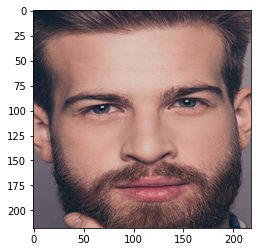

In [11]:
plt.imshow(face_extracted)
plt.show()

In [12]:
# predicting images
from keras.preprocessing import image as imagek
#x = imagek.img_to_array(face_extracted)
x = np.expand_dims(face_extracted, axis=0)

In [13]:
x.shape

(1, 218, 218, 3)

In [14]:
images = np.vstack([x])
pred = model.predict(images, batch_size=10)
print(pred)

[array([[8.9268367e-05, 8.5919988e-01, 1.3322951e-01, 7.4806921e-03,
        3.4644131e-07, 2.5640509e-07, 8.3457445e-09]], dtype=float32), array([[0.50555557, 0.01128922, 0.0567806 , 0.3719861 , 0.05438846]],
      dtype=float32), array([[9.9999774e-01, 3.3167785e-06]], dtype=float32), array([[8.9713991e-01, 2.6291253e-05, 1.0145104e-01, 1.3827578e-03]],
      dtype=float32), array([[9.999919e-01, 2.098714e-05]], dtype=float32), array([[9.9999857e-01, 2.4377266e-06]], dtype=float32)]


In [15]:
for i, k in enumerate(dataset_dict.keys()):
  print(k)
  print(dataset_dict[k][pred[i].argmax(axis=1)[0]])
  print()

age_id
18-25

expression_id
angry

gender_id
Hombre

hair_id
Black_Hair

bald_id
NO calv@

eyeglasses_id
Sin gafas



In [16]:
import os
detector= MTCNN()

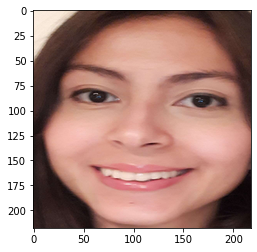

age_id: 25-35   expression_id: happy   gender_id: Mujer   hair_id: Black_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[1.0544696e-07, 6.9631487e-03, 7.1220207e-01, 2.8083473e-01,
        1.0768383e-09, 1.1224459e-09, 2.0802338e-09]], dtype=float32), array([[3.9825713e-07, 1.7046306e-05, 9.9962425e-01, 3.5514863e-04,
        3.2507669e-06]], dtype=float32), array([[3.506229e-08, 1.000000e+00]], dtype=float32), array([[6.3172698e-01, 3.4202867e-07, 3.6827266e-01, 3.5386938e-10]],
      dtype=float32), array([[9.9999750e-01, 5.3380077e-06]], dtype=float32), array([[9.9999511e-01, 1.1068914e-05]], dtype=float32)]





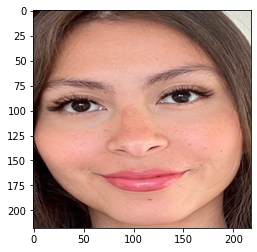

age_id: 25-35   expression_id: happy   gender_id: Mujer   hair_id: Brown_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[2.5418592e-07, 5.2242639e-04, 9.9853611e-01, 9.4031641e-04,
        8.0099676e-07, 2.8481770e-10, 1.0839826e-09]], dtype=float32), array([[6.8177292e-06, 3.1234802e-06, 9.1559076e-01, 8.4399186e-02,
        5.7467396e-08]], dtype=float32), array([[6.670165e-14, 1.000000e+00]], dtype=float32), array([[3.7847656e-08, 1.4844075e-04, 9.9985135e-01, 1.3003665e-07]],
      dtype=float32), array([[0.9994948 , 0.00178509]], dtype=float32), array([[9.9999595e-01, 9.6530566e-06]], dtype=float32)]





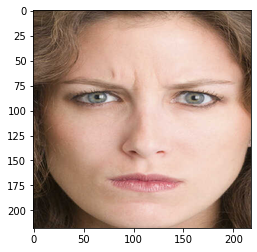

age_id: 25-35   expression_id: angry   gender_id: Mujer   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[4.6380524e-07, 2.4767276e-03, 9.9750656e-01, 1.6241846e-05,
        7.5781124e-09, 7.4027451e-10, 1.6533274e-09]], dtype=float32), array([[8.0900478e-01, 4.1853442e-04, 2.0466482e-04, 1.8569528e-01,
        4.6766847e-03]], dtype=float32), array([[4.341523e-08, 9.999999e-01]], dtype=float32), array([[1.4109917e-09, 5.3707457e-01, 4.6292537e-01, 5.5979278e-08]],
      dtype=float32), array([[9.9999821e-01, 1.9841369e-05]], dtype=float32), array([[9.999993e-01, 7.580622e-07]], dtype=float32)]





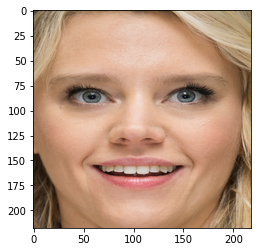

age_id: 25-35   expression_id: happy   gender_id: Mujer   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[1.6045414e-06, 1.8399981e-04, 9.9852824e-01, 1.2841698e-03,
        1.9405213e-06, 3.5443389e-08, 3.4683815e-08]], dtype=float32), array([[3.1078763e-08, 3.8459973e-07, 9.9999821e-01, 1.2232186e-06,
        2.6894131e-07]], dtype=float32), array([[4.706099e-10, 1.000000e+00]], dtype=float32), array([[4.6594219e-14, 1.0000000e+00, 1.3138111e-11, 7.7235522e-13]],
      dtype=float32), array([[9.999982e-01, 3.891557e-06]], dtype=float32), array([[1.000000e+00, 5.245444e-08]], dtype=float32)]





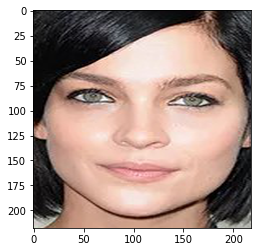

age_id: 25-35   expression_id: happy   gender_id: Mujer   hair_id: Black_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[2.3205077e-07, 3.4855822e-01, 6.5144032e-01, 1.2699234e-06,
        1.3002450e-11, 9.5581919e-12, 1.0699084e-13]], dtype=float32), array([[1.31502375e-05, 3.59114965e-05, 9.96065438e-01, 3.88266076e-03,
        2.80092877e-06]], dtype=float32), array([[1.7140344e-06, 9.9999738e-01]], dtype=float32), array([[0.66281474, 0.334116  , 0.00117526, 0.00189406]], dtype=float32), array([[9.9997759e-01, 2.0676298e-05]], dtype=float32), array([[9.9999845e-01, 7.6889472e-07]], dtype=float32)]





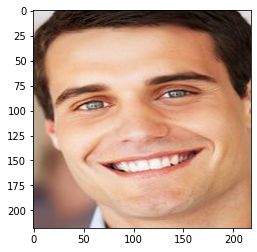

age_id: 18-25   expression_id: happy   gender_id: Hombre   hair_id: Brown_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[2.2723535e-07, 9.7907501e-01, 2.0921489e-02, 3.2638973e-06,
        6.5764351e-12, 3.6777227e-11, 1.1264299e-10]], dtype=float32), array([[7.4261208e-10, 2.5215169e-10, 1.0000000e+00, 7.3684847e-10,
        4.9605320e-11]], dtype=float32), array([[1.0000000e+00, 2.0892161e-09]], dtype=float32), array([[5.4854662e-03, 2.1247565e-06, 9.9451244e-01, 1.7061975e-08]],
      dtype=float32), array([[0.8275265 , 0.27637723]], dtype=float32), array([[9.999360e-01, 2.736851e-05]], dtype=float32)]





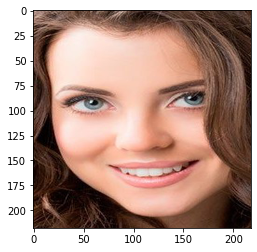

age_id: 18-25   expression_id: happy   gender_id: Mujer   hair_id: Brown_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[9.9754266e-07, 9.7463834e-01, 2.5130432e-02, 2.2917667e-04,
        7.8869914e-07, 1.9943968e-07, 1.7253374e-08]], dtype=float32), array([[2.9870102e-05, 3.5745601e-05, 9.9993420e-01, 2.5742145e-07,
        3.0737283e-08]], dtype=float32), array([[1.2827394e-09, 1.0000000e+00]], dtype=float32), array([[3.3879800e-08, 1.2546245e-04, 9.9987435e-01, 7.8639737e-08]],
      dtype=float32), array([[9.999932e-01, 9.582486e-06]], dtype=float32), array([[9.9999917e-01, 1.0720923e-06]], dtype=float32)]





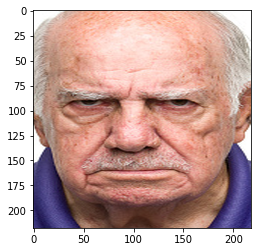

age_id: >60   expression_id: sad   gender_id: Hombre   hair_id: Gray_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[1.2631413e-04, 1.3638864e-04, 6.7670632e-04, 3.1119516e-01,
        1.5679228e-01, 2.1283044e-02, 5.0979006e-01]], dtype=float32), array([[2.07306072e-02, 1.30641520e-05, 6.74400129e-04, 1.18811086e-01,
        8.59770834e-01]], dtype=float32), array([[9.996394e-01, 4.143649e-04]], dtype=float32), array([[4.8873767e-07, 4.8812065e-01, 4.7674047e-09, 5.1187885e-01]],
      dtype=float32), array([[0.9983576 , 0.00206098]], dtype=float32), array([[0.99879324, 0.0020021 ]], dtype=float32)]





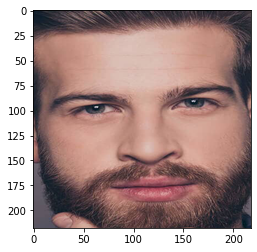

age_id: 35-45   expression_id: angry   gender_id: Hombre   hair_id: Black_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[2.7012060e-04, 2.1572533e-01, 2.3479527e-01, 5.4912311e-01,
        7.0810347e-05, 1.4991128e-05, 3.6292909e-07]], dtype=float32), array([[0.45096746, 0.01426519, 0.19979888, 0.28513882, 0.04982965]],
      dtype=float32), array([[9.9998200e-01, 2.8261986e-05]], dtype=float32), array([[9.7653526e-01, 1.1504992e-04, 7.1059624e-03, 1.6243691e-02]],
      dtype=float32), array([[0.99907875, 0.00368884]], dtype=float32), array([[9.9978977e-01, 2.3779349e-04]], dtype=float32)]





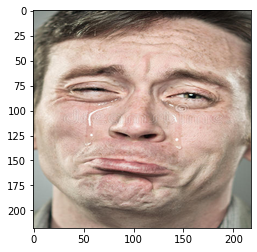

age_id: 18-25   expression_id: fear_surprise   gender_id: Hombre   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[6.4236890e-05, 9.1605163e-01, 3.0187521e-02, 3.6924906e-02,
        1.5075327e-02, 1.6469244e-03, 4.9526159e-05]], dtype=float32), array([[1.5079941e-05, 7.1003801e-01, 8.4295101e-02, 2.0548463e-01,
        1.6715653e-04]], dtype=float32), array([[9.9932814e-01, 9.5339236e-04]], dtype=float32), array([[3.3229124e-03, 9.8470795e-01, 3.2045705e-07, 1.1968824e-02]],
      dtype=float32), array([[0.94993055, 0.0224758 ]], dtype=float32), array([[9.9996483e-01, 7.7128236e-05]], dtype=float32)]





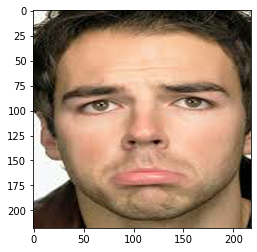

age_id: 18-25   expression_id: neutral   gender_id: Hombre   hair_id: Brown_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[1.7538080e-07, 9.8794889e-01, 1.2048123e-02, 2.8332850e-06,
        3.1724852e-11, 3.6667506e-11, 1.1104399e-11]], dtype=float32), array([[4.4549476e-02, 2.0571642e-01, 1.3648783e-04, 7.4957329e-01,
        2.4420260e-05]], dtype=float32), array([[9.9999809e-01, 2.0128878e-06]], dtype=float32), array([[1.1277988e-01, 3.4596644e-05, 8.8718057e-01, 5.0150725e-06]],
      dtype=float32), array([[9.9995327e-01, 1.2503861e-04]], dtype=float32), array([[9.9996209e-01, 2.7765705e-05]], dtype=float32)]





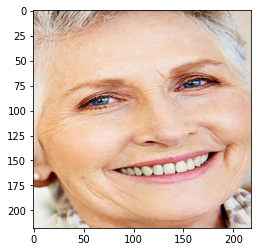

age_id: 35-45   expression_id: neutral   gender_id: Mujer   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[1.9738865e-03, 3.9063412e-01, 1.5338209e-01, 4.5377788e-01,
        8.5744534e-05, 1.1282758e-04, 3.3525663e-05]], dtype=float32), array([[1.9422357e-08, 5.9684207e-06, 5.3078871e-02, 9.4690800e-01,
        7.0684705e-06]], dtype=float32), array([[8.208048e-06, 9.999920e-01]], dtype=float32), array([[6.6646239e-10, 9.9995089e-01, 6.8156608e-10, 4.9108487e-05]],
      dtype=float32), array([[0.9938595 , 0.01502947]], dtype=float32), array([[9.9978131e-01, 1.5267964e-04]], dtype=float32)]





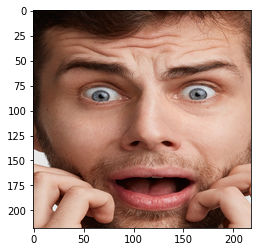

age_id: 35-45   expression_id: fear_surprise   gender_id: Hombre   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[8.2064912e-07, 3.8675991e-01, 1.7333532e-03, 6.1150348e-01,
        2.3103639e-06, 3.3707952e-08, 2.5558984e-08]], dtype=float32), array([[1.7834133e-04, 9.9229723e-01, 7.8286044e-04, 6.5148380e-03,
        2.2658824e-04]], dtype=float32), array([[0.9469849 , 0.12476652]], dtype=float32), array([[0.01482876, 0.49381626, 0.49033728, 0.00101768]], dtype=float32), array([[1.000000e+00, 2.575669e-12]], dtype=float32), array([[1.0000000e+00, 1.9041833e-10]], dtype=float32)]





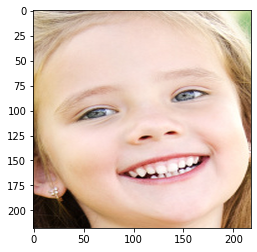

age_id: 25-35   expression_id: happy   gender_id: Mujer   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[5.3373334e-04, 3.9465365e-01, 5.9632701e-01, 1.9019680e-03,
        5.8134156e-03, 7.5797981e-04, 1.2229144e-05]], dtype=float32), array([[1.3883186e-03, 2.1708227e-04, 9.8706287e-01, 7.1905293e-03,
        4.1411389e-03]], dtype=float32), array([[3.4376761e-09, 1.0000000e+00]], dtype=float32), array([[2.3720584e-15, 1.0000000e+00, 5.4527854e-12, 5.4439845e-08]],
      dtype=float32), array([[9.9999905e-01, 1.4351444e-06]], dtype=float32), array([[9.9999988e-01, 1.5933709e-07]], dtype=float32)]





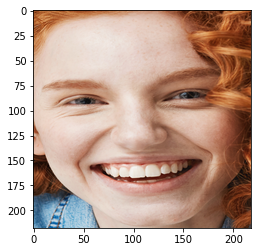

age_id: 18-25   expression_id: happy   gender_id: Mujer   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[1.3553657e-04, 9.0597421e-01, 8.3363377e-02, 1.0422584e-02,
        5.5986835e-05, 2.9769964e-07, 4.8020844e-05]], dtype=float32), array([[9.0068717e-09, 6.7880013e-09, 1.0000000e+00, 4.5934643e-09,
        1.5607773e-09]], dtype=float32), array([[0.00270812, 0.9983865 ]], dtype=float32), array([[1.4165934e-09, 9.8750418e-01, 1.2369268e-02, 1.2660374e-04]],
      dtype=float32), array([[0.98000824, 0.05635682]], dtype=float32), array([[9.9999833e-01, 9.0045444e-07]], dtype=float32)]





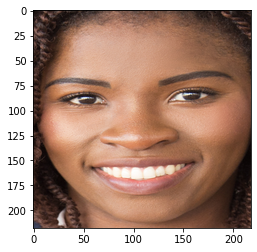

age_id: 25-35   expression_id: happy   gender_id: Mujer   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[2.3678780e-07, 4.7158861e-01, 5.2833426e-01, 7.6882214e-05,
        6.3536254e-10, 2.2902951e-12, 1.5263890e-10]], dtype=float32), array([[2.5558702e-09, 6.2885746e-08, 9.9999905e-01, 7.8843942e-07,
        2.2221462e-09]], dtype=float32), array([[3.5503126e-05, 9.9998713e-01]], dtype=float32), array([[2.2855833e-01, 5.6732506e-01, 2.0411369e-01, 2.9655705e-06]],
      dtype=float32), array([[9.9999917e-01, 3.8017749e-06]], dtype=float32), array([[9.9999774e-01, 2.8019811e-06]], dtype=float32)]





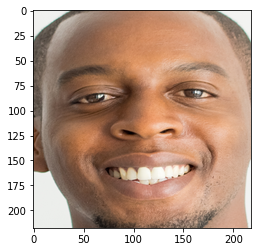

age_id: 35-45   expression_id: happy   gender_id: Hombre   hair_id: Gray_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[1.0417828e-05, 1.7256060e-04, 4.6266668e-02, 9.3764669e-01,
        6.7926678e-03, 1.3468160e-04, 8.9763543e-03]], dtype=float32), array([[2.6604845e-04, 4.3513508e-05, 5.7965893e-01, 4.5713913e-03,
        4.1546017e-01]], dtype=float32), array([[0.9975815 , 0.01057945]], dtype=float32), array([[2.0689301e-03, 1.3931310e-01, 6.9803605e-07, 8.5861725e-01]],
      dtype=float32), array([[9.999976e-01, 5.357871e-07]], dtype=float32), array([[1.000000e+00, 4.470674e-08]], dtype=float32)]





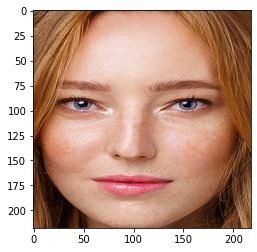

age_id: 18-25   expression_id: neutral   gender_id: Mujer   hair_id: Blond_Hair   bald_id: NO calv@   eyeglasses_id: Sin gafas   

[array([[1.7096570e-05, 7.5778484e-01, 2.4059120e-01, 1.6057137e-03,
        9.0585780e-07, 1.3117648e-07, 1.3842636e-07]], dtype=float32), array([[2.0101079e-07, 6.6084624e-07, 3.3255026e-03, 9.9667275e-01,
        9.1679800e-07]], dtype=float32), array([[9.1894703e-10, 1.0000000e+00]], dtype=float32), array([[1.0586967e-08, 8.8994575e-01, 1.1005430e-01, 5.0021405e-09]],
      dtype=float32), array([[9.9981564e-01, 2.0614396e-04]], dtype=float32), array([[9.9999833e-01, 3.2009873e-06]], dtype=float32)]





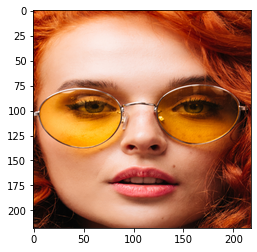

age_id: 25-35   expression_id: neutral   gender_id: Mujer   hair_id: Blond_Hair   bald_id: Calv@   eyeglasses_id: Con gafas   

[array([[1.11763620e-06, 1.20125795e-02, 9.87970412e-01, 1.50400210e-05,
        7.07957724e-07, 6.87175188e-08, 8.07188805e-09]], dtype=float32), array([[4.8932253e-04, 6.8632752e-02, 4.3963924e-02, 7.9590458e-01,
        9.1009513e-02]], dtype=float32), array([[0.0017367 , 0.99619544]], dtype=float32), array([[4.4619687e-02, 6.3925600e-01, 3.1595549e-01, 1.6879826e-04]],
      dtype=float32), array([[6.1549067e-06, 9.9999881e-01]], dtype=float32), array([[6.548157e-06, 9.999962e-01]], dtype=float32)]





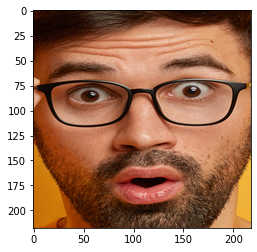

age_id: 25-35   expression_id: fear_surprise   gender_id: Hombre   hair_id: Black_Hair   bald_id: Calv@   eyeglasses_id: Con gafas   

[array([[1.70059540e-08, 1.49215274e-02, 8.73781919e-01, 1.11292526e-01,
        3.95674169e-06, 7.33916972e-09, 3.59960239e-09]], dtype=float32), array([[5.3614739e-04, 9.8425299e-01, 2.5716585e-03, 1.2639071e-02,
        2.3615513e-07]], dtype=float32), array([[1.0000000e+00, 3.4015443e-08]], dtype=float32), array([[9.9710113e-01, 2.4575010e-04, 2.6480015e-03, 5.1912193e-06]],
      dtype=float32), array([[6.3430650e-07, 9.9999607e-01]], dtype=float32), array([[0.11536553, 0.6964576 ]], dtype=float32)]


In [20]:
path = "/content/drive/MyDrive/TFG/fotos"
for file in os.listdir(path):
  print("\n\n")
  face_extracted = extract_face(path+"/"+file, required_size=(WIDTH, HEIGHT), detector=detector) 
  plt.imshow(face_extracted)
  plt.show()
  x = np.expand_dims(face_extracted, axis=0)
  images = np.vstack([x])
  pred = model.predict(images, batch_size=10)
  out_text=''
  for i, k in enumerate(dataset_dict.keys()):
    out_text += str(k)+": "+str(dataset_dict[k][pred[i].argmax(axis=1)[0]])+ "   "
  print(out_text)
  print()
  print(pred)

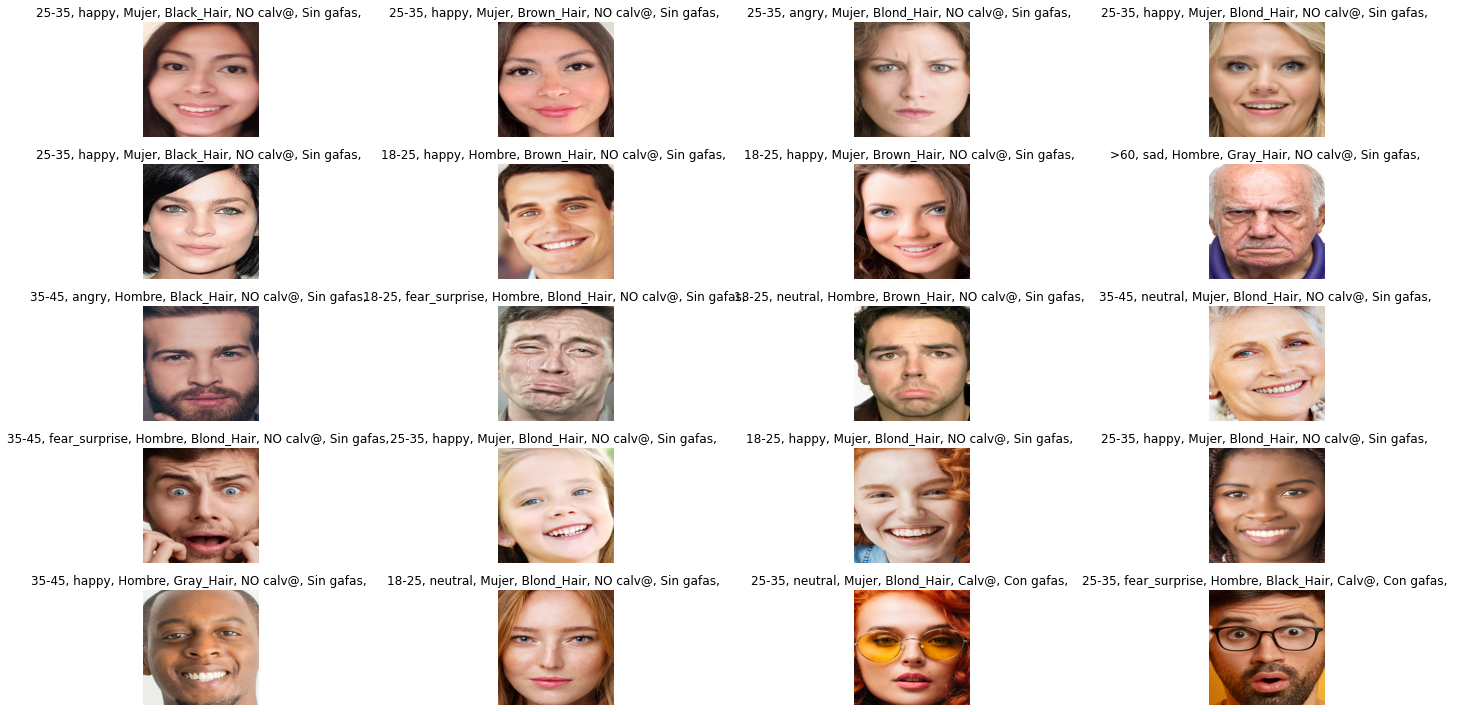

In [21]:

index=0
figsize = (20,10)
fig = plt.figure(figsize=figsize)
for file in os.listdir(path):
    rows = 5
    cols=4
    face_extracted = extract_face(path+"/"+file, required_size=(WIDTH, HEIGHT), detector=detector) 
    x = np.expand_dims(face_extracted, axis=0)
    images = np.vstack([x])
    pred = model.predict(images, batch_size=32)
    out_text=''
    for i, k in enumerate(dataset_dict.keys()):
      out_text += str(dataset_dict[k][pred[i].argmax(axis=1)[0]])+ ", "
    #print(out_text)
    #print()
    #print(pred)

    plt.subplot(rows,cols,index+1)
    plt.axis('off')
    plt.title(str(out_text))
    plt.imshow(face_extracted) 
    plt.tight_layout()
    index=index+1

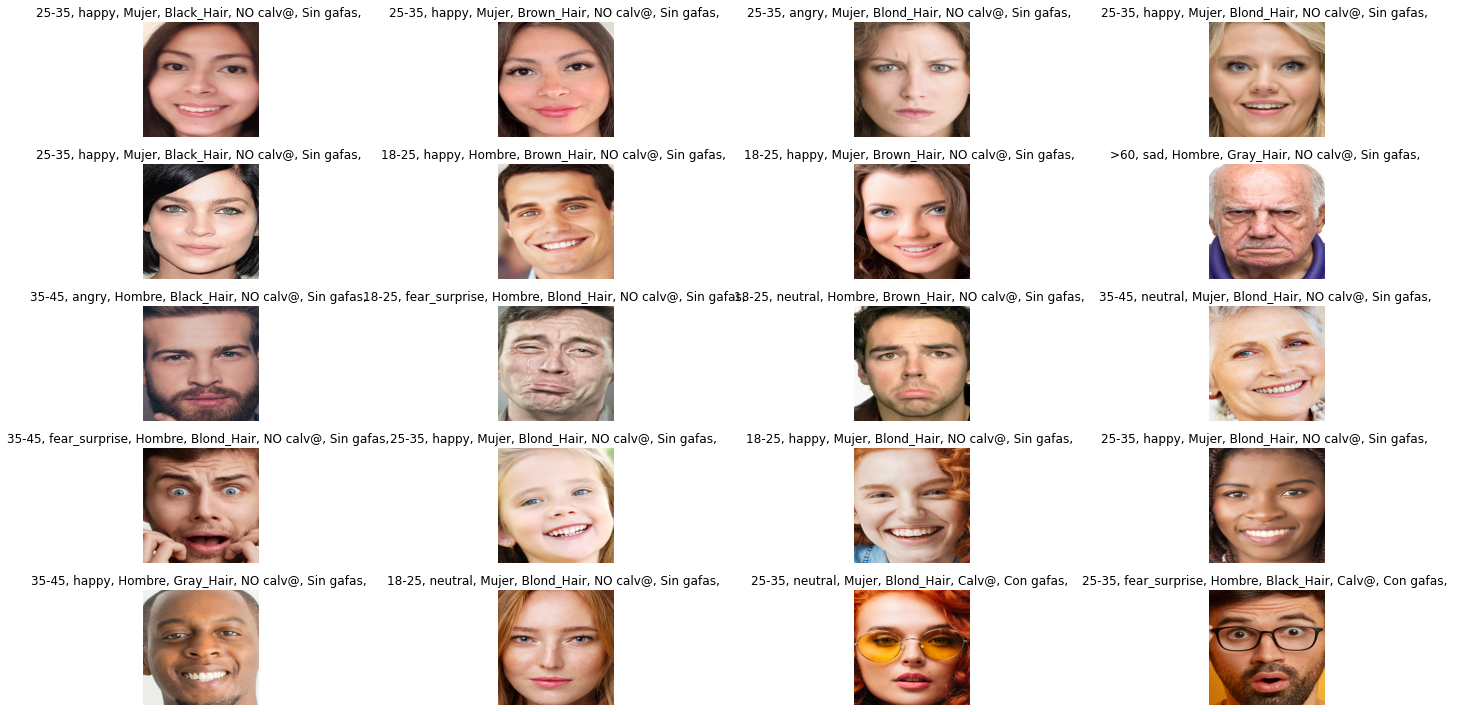

In [22]:

index=0
figsize = (20,10)
fig = plt.figure(figsize=figsize)
for file in os.listdir(path):
    rows = 5
    cols=4
    face_extracted = extract_face(path+"/"+file, required_size=(WIDTH, HEIGHT), detector=detector) 
    x = np.expand_dims(face_extracted, axis=0)
    images = np.vstack([x])
    pred = model.predict(images, batch_size=32)
    out_text=''
    for i, k in enumerate(dataset_dict.keys()):
      out_text += str(dataset_dict[k][pred[i].argmax(axis=1)[0]])+ ", "
    #print(out_text)
    #print()
    #print(pred)

    plt.subplot(rows,cols,index+1)
    plt.axis('off')
    plt.title(str(out_text))
    plt.imshow(face_extracted) 
    plt.tight_layout()
    index=index+1

In [23]:
# ... and use most similar embedding to predict label.
#(sims.argmax(axis=1) == np.array(labels)).mean()
# Expected accuracy for model "LiT-B16B" : 79.19

## Load model

In [24]:
# Installs the vit_jax package from Github.
!pip install -q git+https://github.com/google-research/vision_transformer

     |████████████████████████████████| 92 kB 901 kB/s 
     |████████████████████████████████| 202 kB 68.3 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 4.6 MB 54.8 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
     |████████████████████████████████| 349 kB 75.8 MB/s 
     |████████████████████████████████| 145 kB 79.1 MB/s 
     |████████████████████████████████| 7.6 MB 9.8 MB/s 
     |████████████████████████████████| 217 kB 76.4 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
     |████████████████████████████████| 511.8 MB 8.6 kB/s 
     |████████████████████████████████| 511.7 MB 6.6 kB/s 
     |████████████████████████████████| 511.7 MB 4.5 kB/s 
     |████████████████████████████████| 4.9 MB 56.8 MB/s 


In [25]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm

from vit_jax import models


In [26]:
# Currently available LiT models
[name for name in models.model_configs.MODEL_CONFIGS if name.startswith('LiT')]

['LiT-B16B', 'LiT-B16B_2', 'LiT-L16L', 'LiT-L16S', 'LiT-L16Ti']

In [27]:
model_name = 'LiT-B16B'

lit_model = models.get_model(model_name)
# Loading the variables from cloud can take a while the first time...
lit_variables = lit_model.load_variables()
# Creating tokens from freeform text (see next section).
tokenizer = lit_model.get_tokenizer()
# Resizing images & converting value range to -1..1 (see next section).
image_preprocessing = lit_model.get_image_preprocessing()
# Preprocessing op for use in tfds pipeline (see last section).
pp = lit_model.get_pp()

Loading params from cloud: gs://vit_models/lit/LiT-B16B.npz


100%|██████████| 75/75 [01:31<00:00,  1.22s/it]



⚠️ Reusing local copy: LiT-B16B.npz


## Use model

In [28]:
# Let's load some sample images from tfds.
# Alternatively you can also load these images from the internet / your Drive.
ds = tfds.load('imagenette', split='train')
images_list = [
    example['image'].numpy()
    for _, example in zip(range(5), ds)
]
# Note that this is a list of images with different shapes, not a four
# dimensional tensor.
[image.shape for image in images_list]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incomplete45GLX8/imagenette-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incomplete45GLX8/imagenette-validation.tfrecord*…

Dataset imagenette downloaded and prepared to ~/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.


[(101, 125, 3), (375, 500, 3), (335, 500, 3), (429, 500, 3), (359, 500, 3)]

In [29]:
'''age_branch = self.build_age_branch(inputs)
expression_branch = self.build_expression_branch(inputs, num_facial_expressions)
gender_branch = self.build_gender_branch(inputs)
hair_branch = self.build_hair_branch(inputs, 4)
bald_branch = self.build_bald_branch(inputs)
eyeglasses_branch = self.build_eyeglasses_branch(inputs)'''
dataset_dict_en = {
    'age_id': {
        0: '0-18',
        1: '18-25',
        2: '25-35',  
        3: '35-45', 
        4: '45-55', 
        5: '55-60',
        6: '>60'
    },
    # 'angry', 'fear_surprise', 'happy', 'neutral', 'sad', 
    'expression_id': {
        0: 'angry',  
        1: 'scared or surprised', 
        2: 'happy', 
        3: 'neutral',
        4: 'sad'
    },
    'gender_id': {
        0: "man",
        1: "woman"
    },
    'hair_id': {
        0: 'black Hair',
        1: 'blond Hair',
        2: 'brown Hair',
        3: 'gray Hair',
    },
    'bald_id': {
        0: "not Bald",
        1: "bald"
    },
    'eyeglasses_id': {
        0: "without eyeglasses",
        1: "with eyeglasses"
    }
}

In [30]:
path = "/content/drive/MyDrive/TFG/fotos"
images_list=[]
pred_my_model_text=[]
for file in os.listdir(path):
  
  face_extracted = extract_face(path+"/"+file, required_size=(WIDTH, HEIGHT), detector=detector) 
  x = np.expand_dims(face_extracted, axis=0)
  images = np.vstack([x])
  pred = model.predict(images, batch_size=10)

  out_text =  dataset_dict_en['expression_id'][pred[1].argmax(axis=1)[0]] + " " 

  if pred[4].argmax(axis=1)[0] == 1:
    out_text +=  dataset_dict_en['bald_id'][pred[4].argmax(axis=1)[0]] + " " 

  out_text += dataset_dict_en['gender_id'][pred[2].argmax(axis=1)[0]] + " of "+ dataset_dict_en['age_id'][pred[0].argmax(axis=1)[0]] + " years with "+dataset_dict_en['hair_id'][pred[3].argmax(axis=1)[0]]+ " "

  if pred[5].argmax(axis=1)[0] == 1:
    out_text +=  dataset_dict_en['eyeglasses_id'][pred[5].argmax(axis=1)[0]] + " " 

  images_list.append(face_extracted)
  pred_my_model_text.append(out_text)



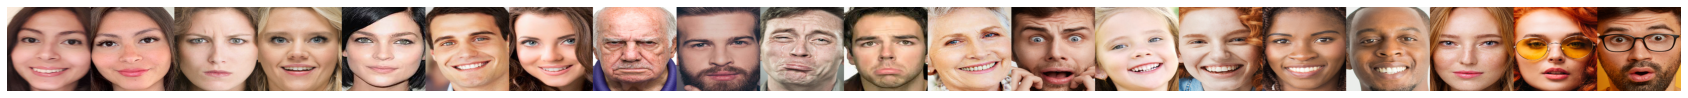

In [31]:
plt.figure(figsize=(30, 20))
plt.imshow(np.hstack(images_list) )
plt.axis('off');

In [32]:
pred_my_model_text

['happy woman of 25-35 years with black Hair ',
 'happy woman of 25-35 years with brown Hair ',
 'angry woman of 25-35 years with blond Hair ',
 'happy woman of 25-35 years with blond Hair ',
 'happy woman of 25-35 years with black Hair ',
 'happy man of 18-25 years with brown Hair ',
 'happy woman of 18-25 years with brown Hair ',
 'sad man of >60 years with gray Hair ',
 'angry man of 35-45 years with black Hair ',
 'scared or surprised man of 18-25 years with blond Hair ',
 'neutral man of 18-25 years with brown Hair ',
 'neutral woman of 35-45 years with blond Hair ',
 'scared or surprised man of 35-45 years with blond Hair ',
 'happy woman of 25-35 years with blond Hair ',
 'happy woman of 18-25 years with blond Hair ',
 'happy woman of 25-35 years with blond Hair ',
 'happy man of 35-45 years with gray Hair ',
 'neutral woman of 18-25 years with blond Hair ',
 'neutral bald woman of 25-35 years with blond Hair with eyeglasses ',
 'scared or surprised bald man of 25-35 years with 

In [33]:
# Note that our preprocessing converts to floats ranging from -1..1 !
images = image_preprocessing(images_list)
images.shape, images.min(), images.max()

((20, 224, 224, 3), -1.0, 1.0)

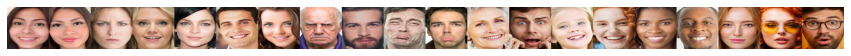

In [34]:
plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(images) * .5 + .5)
plt.axis('off');

In [35]:
tokens = tokenizer(pred_my_model_text)
tokens.shape

(20, 16)

In [36]:
# Embed both texts and images with a single model call.
# See next section for embedding images/texts separately.
zimg, ztxt, out = lit_model.apply(lit_variables, images=images, tokens=tokens)

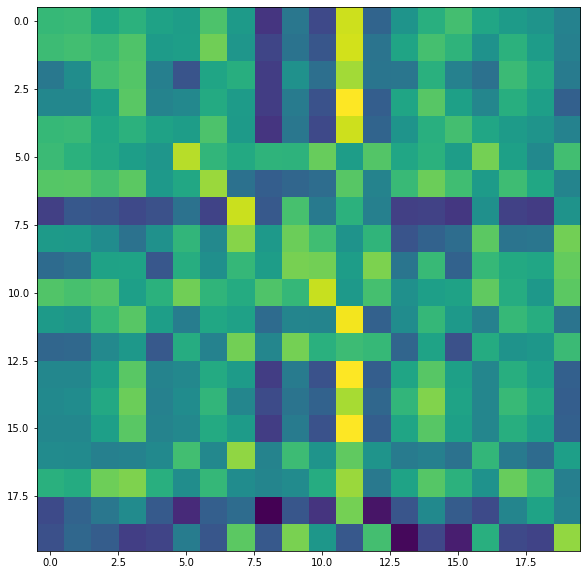

In [37]:
figsize = (20,10)
fig = plt.figure(figsize=figsize)
plt.imshow(ztxt @ zimg.T)

In [38]:
seen = set()
texts_preds_unique = []
conter={}
for x in pred_my_model_text:
    if x not in seen:
        texts_preds_unique.append(x)
        seen.add(x)
        conter[x] = 0
    else:
      c=conter[x]
      conter[x]=conter[x]+1
      x = x + str(c)
      texts_preds_unique.append(x)

In [39]:
texts_preds_unique

['happy woman of 25-35 years with black Hair ',
 'happy woman of 25-35 years with brown Hair ',
 'angry woman of 25-35 years with blond Hair ',
 'happy woman of 25-35 years with blond Hair ',
 'happy woman of 25-35 years with black Hair 0',
 'happy man of 18-25 years with brown Hair ',
 'happy woman of 18-25 years with brown Hair ',
 'sad man of >60 years with gray Hair ',
 'angry man of 35-45 years with black Hair ',
 'scared or surprised man of 18-25 years with blond Hair ',
 'neutral man of 18-25 years with brown Hair ',
 'neutral woman of 35-45 years with blond Hair ',
 'scared or surprised man of 35-45 years with blond Hair ',
 'happy woman of 25-35 years with blond Hair 0',
 'happy woman of 18-25 years with blond Hair ',
 'happy woman of 25-35 years with blond Hair 1',
 'happy man of 35-45 years with gray Hair ',
 'neutral woman of 18-25 years with blond Hair ',
 'neutral bald woman of 25-35 years with blond Hair with eyeglasses ',
 'scared or surprised bald man of 25-35 years wi

In [40]:
tokens = tokenizer(pred_my_model_text)
zimg, ztxt, out = lit_model.apply(lit_variables, images=images, tokens=tokens)

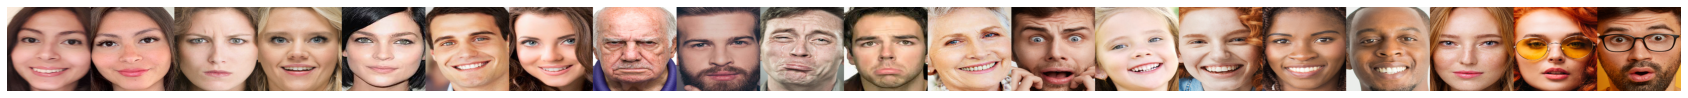

In [41]:
probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
pd.set_option('colheader_justify', 'center')
plt.figure(figsize=(30, 30))
plt.imshow(np.hstack(images_list))
plt.axis('off');
df = pd.DataFrame(probs, index=texts_preds_unique).style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}', )
df = df.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df

In [42]:
pred_my_model_text[-1]

'scared or surprised bald man of 25-35 years with black Hair with eyeglasses '

In [43]:
images[-len(dataset_dict_en['expression_id'].values()):].shape

(5, 224, 224, 3)

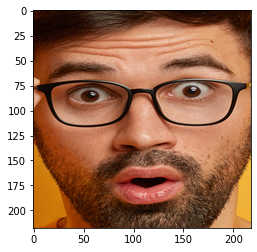

In [44]:
plt.imshow(images_list[-1])

manual_texts=[]
for e in dataset_dict_en['expression_id'].values():
  manual_texts.append(f"{e} man of 35-45 years with black hair with eyeglasses")

manual_texts

tokens = tokenizer(manual_texts)
zimg, ztxt, out = lit_model.apply(lit_variables, images=images[-len(dataset_dict_en['expression_id'].values()):], tokens=tokens)

probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
df = pd.DataFrame(probs, index=manual_texts).iloc[:,4:]
df.columns = ['LiT prob output']
df = df.style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}', )
df = df.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df

In [45]:
images[7:7+len(dataset_dict_en['expression_id'].values())].shape

(5, 224, 224, 3)

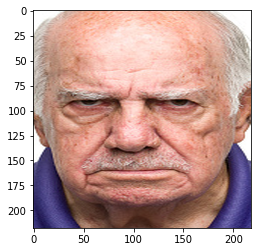

In [52]:
plt.imshow(images_list[7])

manual_texts=[]
for e in dataset_dict_en['expression_id'].values():
  manual_texts.append(f"{e} bald man of >60 years with gray Hair")

manual_texts

tokens = tokenizer(manual_texts)
zimg, ztxt, out = lit_model.apply(lit_variables, images=images[7:7+len(dataset_dict_en['expression_id'].values())], tokens=tokens)

probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
df = pd.DataFrame(probs, index=manual_texts).iloc[:,0:1]
df.columns = ['LiT prob output']
df = df.style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}', )
df = df.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df

(-0.5, 1119.5, 223.5, -0.5)

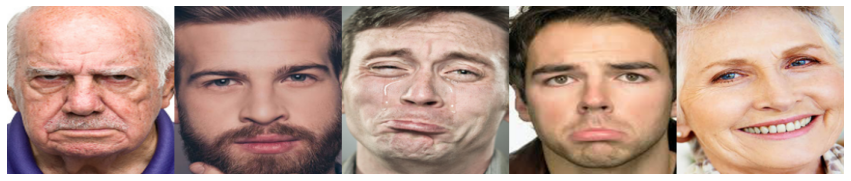

In [47]:

plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(images[7:7+len(dataset_dict_en['expression_id'].values())]) * .5 + .5)
plt.axis('off')

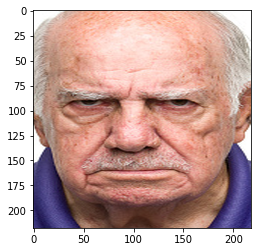

In [48]:
plt.imshow(images_list[7])

manual_texts=[]
for e in dataset_dict_en['expression_id'].values():
  manual_texts.append(f"{e} man")

manual_texts

tokens = tokenizer(manual_texts)
zimg, ztxt, out = lit_model.apply(lit_variables, images=images[7:7+len(dataset_dict_en['expression_id'].values())], tokens=tokens)

probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
df = pd.DataFrame(probs, index=manual_texts).iloc[:,0:1]
df.columns = ['LiT prob output']
df = df.style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}', )
df = df.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df

In [66]:
len(images_list)-6

14

In [78]:
len(images[14:18])

4

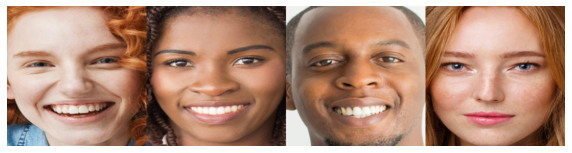

In [79]:
#plt.imshow(images_list[14])

plt.figure(figsize=(10, 4))
plt.imshow(np.hstack(images[14:18]) * .5 + .5)
plt.axis('off')

manual_texts=[]
for e in dataset_dict_en['hair_id'].values():
  manual_texts.append(f"happy woman of 35-45 years with {e}")


manual_texts

tokens = tokenizer(manual_texts)
zimg, ztxt, out = lit_model.apply(lit_variables, images=images[14:18], tokens=tokens)

probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
df = pd.DataFrame(probs, index=manual_texts)#.iloc[:,2:3]
#df.columns = ['LiT prob output']
df = df.style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}', )
df = df.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df

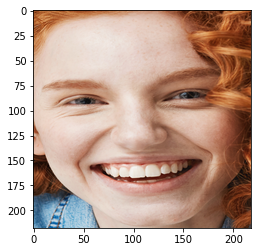

In [81]:
plt.imshow(images_list[14])

manual_texts=[]
for e in dataset_dict_en['hair_id'].values():
  manual_texts.append(f"happy woman with {e}")
manual_texts.append(f"happy woman with red hair")
manual_texts

tokens = tokenizer(manual_texts)
zimg, ztxt, out = lit_model.apply(lit_variables, images=images[14:19], tokens=tokens)

probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
df = pd.DataFrame(probs, index=manual_texts).iloc[:,:1]
df.columns = ['LiT prob output']
df = df.style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}', )
df = df.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df

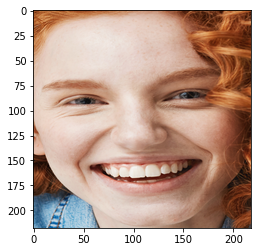

In [55]:
plt.imshow(images_list[-6])

manual_texts=[]
for e in dataset_dict_en['bald_id'].values():
  manual_texts.append(f"happy woman of 35-45 years {e}")

manual_texts

tokens = tokenizer(manual_texts)
zimg, ztxt, out = lit_model.apply(lit_variables, images=images[-len(dataset_dict_en['expression_id'].values()):], tokens=tokens)

probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
df = pd.DataFrame(probs, index=manual_texts).iloc[:,2:3]
df.columns = ['LiT prob output']
df = df.style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}', )
df = df.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df

In [ ]:
# Note that our preprocessing converts to floats ranging from -1..1 !
images = image_preprocessing(images_list)
images.shape, images.min(), images.max()

((5, 224, 224, 3), -1.0, 1.0)

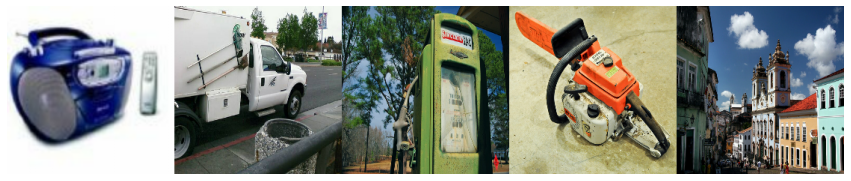

In [ ]:
plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(images) * .5 + .5)
plt.axis('off');

In [ ]:
texts = [
    'itap of a cd player',
    'a photo of a truck',
    'gas station',
    'chainsaw',
    'a bad photo of colorful houses',
]
tokens = tokenizer(texts)
tokens.shape

(5, 16)

In [ ]:
# Embed both texts and images with a single model call.
# See next section for embedding images/texts separately.
zimg, ztxt, out = lit_model.apply(lit_variables, images=images, tokens=tokens)

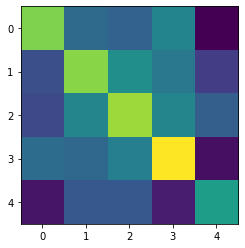

In [ ]:
plt.imshow(ztxt @ zimg.T)

In [ ]:
probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
pd.DataFrame(probs, index=texts).style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}')

## `tfds` zero-shot evaluation

In [ ]:
#@markdown `imagenet_classnames`
# From https://github.com/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb
imagenet_classnames = "tench;goldfish;great white shark;tiger shark;hammerhead shark;electric ray;stingray;rooster;hen;ostrich;brambling;goldfinch;house finch;junco;indigo bunting;American robin;bulbul;jay;magpie;chickadee;American dipper;kite (bird of prey);bald eagle;vulture;great grey owl;fire salamander;smooth newt;newt;spotted salamander;axolotl;American bullfrog;tree frog;tailed frog;loggerhead sea turtle;leatherback sea turtle;mud turtle;terrapin;box turtle;banded gecko;green iguana;Carolina anole;desert grassland whiptail lizard;agama;frilled-necked lizard;alligator lizard;Gila monster;European green lizard;chameleon;Komodo dragon;Nile crocodile;American alligator;triceratops;worm snake;ring-necked snake;eastern hog-nosed snake;smooth green snake;kingsnake;garter snake;water snake;vine snake;night snake;boa constrictor;African rock python;Indian cobra;green mamba;sea snake;Saharan horned viper;eastern diamondback rattlesnake;sidewinder rattlesnake;trilobite;harvestman;scorpion;yellow garden spider;barn spider;European garden spider;southern black widow;tarantula;wolf spider;tick;centipede;black grouse;ptarmigan;ruffed grouse;prairie grouse;peafowl;quail;partridge;african grey parrot;macaw;sulphur-crested cockatoo;lorikeet;coucal;bee eater;hornbill;hummingbird;jacamar;toucan;duck;red-breasted merganser;goose;black swan;tusker;echidna;platypus;wallaby;koala;wombat;jellyfish;sea anemone;brain coral;flatworm;nematode;conch;snail;slug;sea slug;chiton;chambered nautilus;Dungeness crab;rock crab;fiddler crab;red king crab;American lobster;spiny lobster;crayfish;hermit crab;isopod;white stork;black stork;spoonbill;flamingo;little blue heron;great egret;bittern bird;crane bird;limpkin;common gallinule;American coot;bustard;ruddy turnstone;dunlin;common redshank;dowitcher;oystercatcher;pelican;king penguin;albatross;grey whale;killer whale;dugong;sea lion;Chihuahua;Japanese Chin;Maltese;Pekingese;Shih Tzu;King Charles Spaniel;Papillon;toy terrier;Rhodesian Ridgeback;Afghan Hound;Basset Hound;Beagle;Bloodhound;Bluetick Coonhound;Black and Tan Coonhound;Treeing Walker Coonhound;English foxhound;Redbone Coonhound;borzoi;Irish Wolfhound;Italian Greyhound;Whippet;Ibizan Hound;Norwegian Elkhound;Otterhound;Saluki;Scottish Deerhound;Weimaraner;Staffordshire Bull Terrier;American Staffordshire Terrier;Bedlington Terrier;Border Terrier;Kerry Blue Terrier;Irish Terrier;Norfolk Terrier;Norwich Terrier;Yorkshire Terrier;Wire Fox Terrier;Lakeland Terrier;Sealyham Terrier;Airedale Terrier;Cairn Terrier;Australian Terrier;Dandie Dinmont Terrier;Boston Terrier;Miniature Schnauzer;Giant Schnauzer;Standard Schnauzer;Scottish Terrier;Tibetan Terrier;Australian Silky Terrier;Soft-coated Wheaten Terrier;West Highland White Terrier;Lhasa Apso;Flat-Coated Retriever;Curly-coated Retriever;Golden Retriever;Labrador Retriever;Chesapeake Bay Retriever;German Shorthaired Pointer;Vizsla;English Setter;Irish Setter;Gordon Setter;Brittany dog;Clumber Spaniel;English Springer Spaniel;Welsh Springer Spaniel;Cocker Spaniel;Sussex Spaniel;Irish Water Spaniel;Kuvasz;Schipperke;Groenendael dog;Malinois;Briard;Australian Kelpie;Komondor;Old English Sheepdog;Shetland Sheepdog;collie;Border Collie;Bouvier des Flandres dog;Rottweiler;German Shepherd Dog;Dobermann;Miniature Pinscher;Greater Swiss Mountain Dog;Bernese Mountain Dog;Appenzeller Sennenhund;Entlebucher Sennenhund;Boxer;Bullmastiff;Tibetan Mastiff;French Bulldog;Great Dane;St. Bernard;husky;Alaskan Malamute;Siberian Husky;Dalmatian;Affenpinscher;Basenji;pug;Leonberger;Newfoundland dog;Great Pyrenees dog;Samoyed;Pomeranian;Chow Chow;Keeshond;brussels griffon;Pembroke Welsh Corgi;Cardigan Welsh Corgi;Toy Poodle;Miniature Poodle;Standard Poodle;Mexican hairless dog (xoloitzcuintli);grey wolf;Alaskan tundra wolf;red wolf or maned wolf;coyote;dingo;dhole;African wild dog;hyena;red fox;kit fox;Arctic fox;grey fox;tabby cat;tiger cat;Persian cat;Siamese cat;Egyptian Mau;cougar;lynx;leopard;snow leopard;jaguar;lion;tiger;cheetah;brown bear;American black bear;polar bear;sloth bear;mongoose;meerkat;tiger beetle;ladybug;ground beetle;longhorn beetle;leaf beetle;dung beetle;rhinoceros beetle;weevil;fly;bee;ant;grasshopper;cricket insect;stick insect;cockroach;praying mantis;cicada;leafhopper;lacewing;dragonfly;damselfly;red admiral butterfly;ringlet butterfly;monarch butterfly;small white butterfly;sulphur butterfly;gossamer-winged butterfly;starfish;sea urchin;sea cucumber;cottontail rabbit;hare;Angora rabbit;hamster;porcupine;fox squirrel;marmot;beaver;guinea pig;common sorrel horse;zebra;pig;wild boar;warthog;hippopotamus;ox;water buffalo;bison;ram (adult male sheep);bighorn sheep;Alpine ibex;hartebeest;impala (antelope);gazelle;arabian camel;llama;weasel;mink;European polecat;black-footed ferret;otter;skunk;badger;armadillo;three-toed sloth;orangutan;gorilla;chimpanzee;gibbon;siamang;guenon;patas monkey;baboon;macaque;langur;black-and-white colobus;proboscis monkey;marmoset;white-headed capuchin;howler monkey;titi monkey;Geoffroy's spider monkey;common squirrel monkey;ring-tailed lemur;indri;Asian elephant;African bush elephant;red panda;giant panda;snoek fish;eel;silver salmon;rock beauty fish;clownfish;sturgeon;gar fish;lionfish;pufferfish;abacus;abaya;academic gown;accordion;acoustic guitar;aircraft carrier;airliner;airship;altar;ambulance;amphibious vehicle;analog clock;apiary;apron;trash can;assault rifle;backpack;bakery;balance beam;balloon;ballpoint pen;Band-Aid;banjo;baluster / handrail;barbell;barber chair;barbershop;barn;barometer;barrel;wheelbarrow;baseball;basketball;bassinet;bassoon;swimming cap;bath towel;bathtub;station wagon;lighthouse;beaker;military hat (bearskin or shako);beer bottle;beer glass;bell tower;baby bib;tandem bicycle;bikini;ring binder;binoculars;birdhouse;boathouse;bobsleigh;bolo tie;poke bonnet;bookcase;bookstore;bottle cap;hunting bow;bow tie;brass memorial plaque;bra;breakwater;breastplate;broom;bucket;buckle;bulletproof vest;high-speed train;butcher shop;taxicab;cauldron;candle;cannon;canoe;can opener;cardigan;car mirror;carousel;tool kit;cardboard box / carton;car wheel;automated teller machine;cassette;cassette player;castle;catamaran;CD player;cello;mobile phone;chain;chain-link fence;chain mail;chainsaw;storage chest;chiffonier;bell or wind chime;china cabinet;Christmas stocking;church;movie theater;cleaver;cliff dwelling;cloak;clogs;cocktail shaker;coffee mug;coffeemaker;spiral or coil;combination lock;computer keyboard;candy store;container ship;convertible;corkscrew;cornet;cowboy boot;cowboy hat;cradle;construction crane;crash helmet;crate;infant bed;Crock Pot;croquet ball;crutch;cuirass;dam;desk;desktop computer;rotary dial telephone;diaper;digital clock;digital watch;dining table;dishcloth;dishwasher;disc brake;dock;dog sled;dome;doormat;drilling rig;drum;drumstick;dumbbell;Dutch oven;electric fan;electric guitar;electric locomotive;entertainment center;envelope;espresso machine;face powder;feather boa;filing cabinet;fireboat;fire truck;fire screen;flagpole;flute;folding chair;football helmet;forklift;fountain;fountain pen;four-poster bed;freight car;French horn;frying pan;fur coat;garbage truck;gas mask or respirator;gas pump;goblet;go-kart;golf ball;golf cart;gondola;gong;gown;grand piano;greenhouse;radiator grille;grocery store;guillotine;hair clip;hair spray;half-track;hammer;hamper;hair dryer;hand-held computer;handkerchief;hard disk drive;harmonica;harp;combine harvester;hatchet;holster;home theater;honeycomb;hook;hoop skirt;gymnastic horizontal bar;horse-drawn vehicle;hourglass;iPod;clothes iron;carved pumpkin;jeans;jeep;T-shirt;jigsaw puzzle;rickshaw;joystick;kimono;knee pad;knot;lab coat;ladle;lampshade;laptop computer;lawn mower;lens cap;letter opener;library;lifeboat;lighter;limousine;ocean liner;lipstick;slip-on shoe;lotion;music speaker;loupe magnifying glass;sawmill;magnetic compass;messenger bag;mailbox;tights;one-piece bathing suit;manhole cover;maraca;marimba;mask;matchstick;maypole;maze;measuring cup;medicine cabinet;megalith;microphone;microwave oven;military uniform;milk can;minibus;miniskirt;minivan;missile;mitten;mixing bowl;mobile home;ford model t;modem;monastery;monitor;moped;mortar and pestle;graduation cap;mosque;mosquito net;vespa;mountain bike;tent;computer mouse;mousetrap;moving van;muzzle;metal nail;neck brace;necklace;baby pacifier;notebook computer;obelisk;oboe;ocarina;odometer;oil filter;pipe organ;oscilloscope;overskirt;bullock cart;oxygen mask;product packet / packaging;paddle;paddle wheel;padlock;paintbrush;pajamas;palace;pan flute;paper towel;parachute;parallel bars;park bench;parking meter;railroad car;patio;payphone;pedestal;pencil case;pencil sharpener;perfume;Petri dish;photocopier;plectrum;Pickelhaube;picket fence;pickup truck;pier;piggy bank;pill bottle;pillow;ping-pong ball;pinwheel;pirate ship;drink pitcher;block plane;planetarium;plastic bag;plate rack;farm plow;plunger;Polaroid camera;pole;police van;poncho;pool table;soda bottle;plant pot;potter's wheel;power drill;prayer rug;printer;prison;missile;projector;hockey puck;punching bag;purse;quill;quilt;race car;racket;radiator;radio;radio telescope;rain barrel;recreational vehicle;fishing casting reel;reflex camera;refrigerator;remote control;restaurant;revolver;rifle;rocking chair;rotisserie;eraser;rugby ball;ruler measuring stick;sneaker;safe;safety pin;salt shaker;sandal;sarong;saxophone;scabbard;weighing scale;school bus;schooner;scoreboard;CRT monitor;screw;screwdriver;seat belt;sewing machine;shield;shoe store;shoji screen / room divider;shopping basket;shopping cart;shovel;shower cap;shower curtain;ski;balaclava ski mask;sleeping bag;slide rule;sliding door;slot machine;snorkel;snowmobile;snowplow;soap dispenser;soccer ball;sock;solar thermal collector;sombrero;soup bowl;keyboard space bar;space heater;space shuttle;spatula;motorboat;spider web;spindle;sports car;spotlight;stage;steam locomotive;through arch bridge;steel drum;stethoscope;scarf;stone wall;stopwatch;stove;strainer;tram;stretcher;couch;stupa;submarine;suit;sundial;sunglasses;sunglasses;sunscreen;suspension bridge;mop;sweatshirt;swim trunks / shorts;swing;electrical switch;syringe;table lamp;tank;tape player;teapot;teddy bear;television;tennis ball;thatched roof;front curtain;thimble;threshing machine;throne;tile roof;toaster;tobacco shop;toilet seat;torch;totem pole;tow truck;toy store;tractor;semi-trailer truck;tray;trench coat;tricycle;trimaran;tripod;triumphal arch;trolleybus;trombone;hot tub;turnstile;typewriter keyboard;umbrella;unicycle;upright piano;vacuum cleaner;vase;vaulted or arched ceiling;velvet fabric;vending machine;vestment;viaduct;violin;volleyball;waffle iron;wall clock;wallet;wardrobe;military aircraft;sink;washing machine;water bottle;water jug;water tower;whiskey jug;whistle;hair wig;window screen;window shade;Windsor tie;wine bottle;airplane wing;wok;wooden spoon;wool;split-rail fence;shipwreck;sailboat;yurt;website;comic book;crossword;traffic or street sign;traffic light;dust jacket;menu;plate;guacamole;consomme;hot pot;trifle;ice cream;popsicle;baguette;bagel;pretzel;cheeseburger;hot dog;mashed potatoes;cabbage;broccoli;cauliflower;zucchini;spaghetti squash;acorn squash;butternut squash;cucumber;artichoke;bell pepper;cardoon;mushroom;Granny Smith apple;strawberry;orange;lemon;fig;pineapple;banana;jackfruit;cherimoya (custard apple);pomegranate;hay;carbonara;chocolate syrup;dough;meatloaf;pizza;pot pie;burrito;red wine;espresso;tea cup;eggnog;mountain;bubble;cliff;coral reef;geyser;lakeshore;promontory;sandbar;beach;valley;volcano;baseball player;bridegroom;scuba diver;rapeseed;daisy;yellow lady's slipper;corn;acorn;rose hip;horse chestnut seed;coral fungus;agaric;gyromitra;stinkhorn mushroom;earth star fungus;hen of the woods mushroom;bolete;corn cob;toilet paper".split(';')


In [ ]:
# # For imagenet evaluation, first prepare the dataset on a GCS bucket as
# # described in
# # https://www.tensorflow.org/datasets/catalog/imagenet2012
# # and then replace `data_dir` below with that GCS bucket.
# from google.colab import auth
# auth.authenticate_user()  # Required to access access protected GCS buckets.
# builder = tfds.builder('imagenet2012', data_dir='gs://tensorflow-datasets/datasets')
# ds_test = builder.as_dataset('validation')
# info = builder.info
# classnames = imagenet_classnames

In [ ]:
# Load dataset and create array of class names.
builder = tfds.builder('cifar100')
builder.download_and_prepare()
ds_test = builder.as_dataset('test')
info = builder.info
classnames = [
    info.features['label'].int2str(id_)
    for id_ in range(info.features['label'].num_classes)
]
classnames[:10]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar100/3.0.2.incompleteSIB63P/cifar100-train.tfrecord*...:   0%|          | …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar100/3.0.2.incompleteSIB63P/cifar100-test.tfrecord*...:   0%|          | 0…

Dataset cifar100 downloaded and prepared to ~/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

In [ ]:
#@markdown `PROMPTS80`
PROMPTS80 = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]


In [ ]:
# The official CLIP Colab
# https://github.com/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb
# lists two sets of prompts: the 80 prompts mentioned in the CLIP paper
# (https://arxiv.org/abs/2103.00020), as well as a shortlist of 7 prompts that
# we'll be using by default below.

PROMPTS = [
    'itap of a {}.',
    'a bad photo of the {}.',
    'a origami {}.',
    'a photo of the large {}.',
    'a {} in a video game.',
    'art of the {}.',
    'a photo of the small {}.',
    '{}',
]
# PROMPTS = PROMPTS80

texts = [
    prompt.format(classname)
    for classname in classnames
    for prompt in PROMPTS
]
len(texts)

800

In [ ]:
# Tokenize the texts using numpy like before.
tokens = tokenizer(texts)
tokens.shape

(800, 16)

In [ ]:
_, ztxt, _ = lit_model.apply(lit_variables, tokens=tokens)
ztxt.shape

(800, 768)

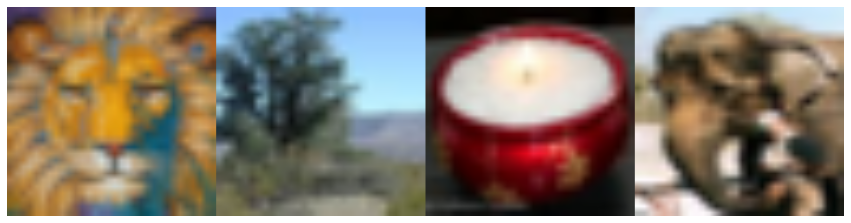

In [ ]:
# `pp` from above (section "Load model") is a TensorFlow graph that can
# efficiently be added to the input pre-processing.
imgs = next(iter(ds_test.map(pp).batch(4)))['image']
# Note that `pp` would also tokenize "texts" to "tokens", if such a feature was
# present in the dataset (which is not the case for cifar).

plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(imgs) * .5 + .5)
plt.axis('off');

In [ ]:
# JIT-compile image embedding function because there are lots of images.
@jax.jit
def embed_images(variables, images):
  zimg, _, _ = lit_model.apply(variables, images=images)
  return zimg

In [ ]:
# Compute all images embeddings & collect correct labels.
zimgs = []
labels = []

for batch in tqdm.tqdm(ds_test.map(lit_model.get_pp()).batch(500)):
  labels += list(batch['label'].numpy())
  zimg = embed_images(lit_variables, batch['image'].numpy())
  zimgs.append(np.array(zimg))
zimgs = np.concatenate(zimgs)
zimgs.shape

100%|██████████| 20/20 [02:29<00:00,  7.49s/it]


(10000, 768)

In [ ]:
# Compute similarities ...
sims = zimgs @ ztxt.reshape([len(classnames), len(PROMPTS), -1]).mean(axis=1).T
sims.shape

(10000, 100)